## Conv1D + LSTM Layers:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Build the Model:

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(50)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 866ms/step - loss: 28.4880 - mae: 28.9462
Epoch 2/100
8/8 [==============================] - 1s 83ms/step - loss: 26.5725 - mae: 26.9823
Epoch 3/100
8/8 [==============================] - 1s 86ms/step - loss: 23.9303 - mae: 24.4934
Epoch 4/100
8/8 [==============================] - 1s 76ms/step - loss: 22.0303 - mae: 22.4958
Epoch 5/100
8/8 [==============================] - 1s 78ms/step - loss: 20.8943 - mae: 21.3784
Epoch 6/100
8/8 [==============================] - 1s 83ms/step - loss: 20.3506 - mae: 20.8574
Epoch 7/100
8/8 [==============================] - 1s 77ms/step - loss: 20.1186 - mae: 20.6409
Epoch 8/100
8/8 [==============================] - 1s 86ms/step - loss: 20.0225 - mae: 20.4690
Epoch 9/100
8/8 [==============================] - 1s 102ms/step - loss: 19.8242 - mae: 20.2805
Epoch 10/100
8/8 [==============================] - 1s 90ms/step - loss: 19.4821 - mae: 20.0617
Epoch 11/100
8/8 [=============================

8/8 [==============================] - 1s 77ms/step - loss: 18.0490 - mae: 18.3855
Epoch 88/100
8/8 [==============================] - 1s 75ms/step - loss: 10.9436 - mae: 11.6755
Epoch 89/100
8/8 [==============================] - 1s 77ms/step - loss: 10.8795 - mae: 11.1597
Epoch 90/100
8/8 [==============================] - 1s 76ms/step - loss: 12.1359 - mae: 12.8212
Epoch 91/100
8/8 [==============================] - 1s 75ms/step - loss: 15.1692 - mae: 15.7046
Epoch 92/100
8/8 [==============================] - 1s 75ms/step - loss: 9.2689 - mae: 9.8957
Epoch 93/100
8/8 [==============================] - 1s 75ms/step - loss: 11.7751 - mae: 11.4263
Epoch 94/100
8/8 [==============================] - 1s 76ms/step - loss: 22.3316 - mae: 22.5859
Epoch 95/100
8/8 [==============================] - 1s 75ms/step - loss: 14.1962 - mae: 14.8958
Epoch 96/100
8/8 [==============================] - 1s 75ms/step - loss: 16.7915 - mae: 17.5526
Epoch 97/100
8/8 [==============================] - 1s 

[1e-08, 0.0001, 0, 30]

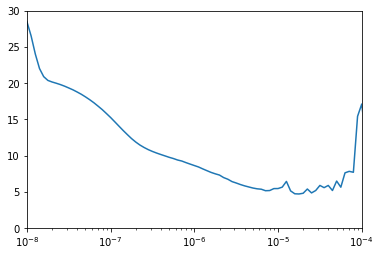

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 123ms/step - loss: 21.5713 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 1s 31ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 1s 32ms/step - loss: 6.6375 - mae: 7.1300
Epoch 4/500
31/31 [==============================] - 1s 32ms/step - loss: 6.4608 - mae: 6.9360
Epoch 5/500
31/31 [==============================] - 1s 36ms/step - loss: 5.8228 - mae: 6.3143
Epoch 6/500
31/31 [==============================] - 1s 33ms/step - loss: 5.6087 - mae: 6.0922
Epoch 7/500
31/31 [==============================] - 1s 34ms/step - loss: 5.4347 - mae: 5.9129
Epoch 8/500
31/31 [==============================] - 1s 33ms/step - loss: 5.3849 - mae: 5.8633
Epoch 9/500
31/31 [==============================] - 1s 34ms/step - loss: 5.2433 - mae: 5.7367
Epoch 10/500
31/31 [==============================] - 1s 32ms/step - loss: 5.1676 - mae: 5.6543
Epoch 11/500
31/31 [==========================

31/31 [==============================] - 1s 32ms/step - loss: 4.3647 - mae: 4.8433
Epoch 87/500
31/31 [==============================] - 1s 33ms/step - loss: 4.2636 - mae: 4.7396
Epoch 88/500
31/31 [==============================] - 1s 30ms/step - loss: 4.2940 - mae: 4.7668
Epoch 89/500
31/31 [==============================] - 1s 30ms/step - loss: 4.2208 - mae: 4.7061
Epoch 90/500
31/31 [==============================] - 1s 30ms/step - loss: 4.2218 - mae: 4.6910
Epoch 91/500
31/31 [==============================] - 1s 30ms/step - loss: 4.2286 - mae: 4.7037
Epoch 92/500
31/31 [==============================] - 1s 36ms/step - loss: 4.2347 - mae: 4.7128
Epoch 93/500
31/31 [==============================] - 1s 34ms/step - loss: 4.2128 - mae: 4.6850
Epoch 94/500
31/31 [==============================] - 1s 32ms/step - loss: 4.2078 - mae: 4.6722
Epoch 95/500
31/31 [==============================] - 1s 35ms/step - loss: 4.2406 - mae: 4.7146
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 33ms/step - loss: 4.1077 - mae: 4.5821
Epoch 171/500
31/31 [==============================] - 1s 32ms/step - loss: 4.2743 - mae: 4.7429
Epoch 172/500
31/31 [==============================] - 1s 32ms/step - loss: 4.1234 - mae: 4.6025
Epoch 173/500
31/31 [==============================] - 1s 32ms/step - loss: 4.1533 - mae: 4.6238
Epoch 174/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0993 - mae: 4.5699
Epoch 175/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0884 - mae: 4.5636
Epoch 176/500
31/31 [==============================] - 1s 34ms/step - loss: 4.1353 - mae: 4.6001
Epoch 177/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1737 - mae: 4.6468
Epoch 178/500
31/31 [==============================] - 1s 34ms/step - loss: 4.1081 - mae: 4.5724
Epoch 179/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0991 - mae: 4.5687
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 31ms/step - loss: 4.0441 - mae: 4.5158
Epoch 255/500
31/31 [==============================] - 1s 32ms/step - loss: 4.0290 - mae: 4.5041
Epoch 256/500
31/31 [==============================] - 1s 34ms/step - loss: 4.0999 - mae: 4.5769
Epoch 257/500
31/31 [==============================] - 1s 31ms/step - loss: 4.1010 - mae: 4.5819
Epoch 258/500
31/31 [==============================] - 1s 32ms/step - loss: 4.0843 - mae: 4.5553
Epoch 259/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0483 - mae: 4.5178
Epoch 260/500
31/31 [==============================] - 1s 31ms/step - loss: 4.0553 - mae: 4.5322
Epoch 261/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1403 - mae: 4.6054
Epoch 262/500
31/31 [==============================] - 1s 36ms/step - loss: 4.1408 - mae: 4.6203
Epoch 263/500
31/31 [==============================] - 1s 34ms/step - loss: 4.0964 - mae: 4.5634
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 32ms/step - loss: 4.1010 - mae: 4.5733
Epoch 339/500
31/31 [==============================] - 1s 31ms/step - loss: 4.0023 - mae: 4.4792
Epoch 340/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9739 - mae: 4.4478
Epoch 341/500
31/31 [==============================] - 1s 32ms/step - loss: 4.0538 - mae: 4.5162
Epoch 342/500
31/31 [==============================] - 1s 32ms/step - loss: 4.0546 - mae: 4.5386
Epoch 343/500
31/31 [==============================] - 1s 31ms/step - loss: 4.0032 - mae: 4.4749
Epoch 344/500
31/31 [==============================] - 1s 32ms/step - loss: 4.0019 - mae: 4.4721
Epoch 345/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0262 - mae: 4.5039
Epoch 346/500
31/31 [==============================] - 1s 31ms/step - loss: 4.0169 - mae: 4.4903
Epoch 347/500
31/31 [==============================] - 1s 33ms/step - loss: 3.9804 - mae: 4.4520
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 32ms/step - loss: 3.9385 - mae: 4.4059
Epoch 423/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9428 - mae: 4.4129
Epoch 424/500
31/31 [==============================] - 1s 31ms/step - loss: 3.9514 - mae: 4.4179
Epoch 425/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9544 - mae: 4.4187
Epoch 426/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9500 - mae: 4.4242
Epoch 427/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9461 - mae: 4.4204
Epoch 428/500
31/31 [==============================] - 1s 34ms/step - loss: 3.9835 - mae: 4.4603
Epoch 429/500
31/31 [==============================] - 1s 33ms/step - loss: 3.9494 - mae: 4.4246
Epoch 430/500
31/31 [==============================] - 1s 34ms/step - loss: 3.9402 - mae: 4.4097
Epoch 431/500
31/31 [==============================] - 1s 33ms/step - loss: 3.9899 - mae: 4.4652
Epoch 432/500
31/31 [=======================